# ISO-SWS data preprocessing: convert to pickled dataframes

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from IPython.core.debugger import set_trace as st
from scipy.interpolate import splev, splrep
from spectres import spectres

In [2]:
def downsample_to_cassis_interpolate(df):
    """Downsample to match the wavelength grid of CASSIS."""
    
    wave = df['wavelength']
    flux = df['flux']
    spec_error = df['spec_error']
    norm_error = df['norm_error']

    def spline(x, y, new_x):
        spline_model = splrep(x=x, y=y)
        new_y = splev(x=new_x, tck=spline_model)
        return new_y

    new_wave = cassis_wave
    new_flux = spline(wave, flux, new_wave)
    new_spec_error = spline(wave, spec_error, new_wave)
    new_norm_error = spline(wave, norm_error, new_wave)

    col_stack = np.column_stack([new_wave, new_flux, new_spec_error, new_norm_error])
    col_names = ['wavelength', 'flux', 'spec_error', 'norm_error']

    df2 = pd.DataFrame(col_stack, columns=col_names)
    
    return df2

def downsample_to_cassis_spectres(df):
    """Downsample to match the wavelength grid of CASSIS."""

    def spline(x, y, new_x):
        spline_model = splrep(x=x, y=y)
        new_y = splev(x=new_x, tck=spline_model)
        return new_y
      
    wave = df['wavelength']
    flux = df['flux']
    spec_error = df['spec_error']
    norm_error = df['norm_error']

    wave = wave.values
    flux = flux.values
    spec_error = spec_error.values
    norm_error = norm_error.values
    
    new_wave = cassis_wave
    new_flux, new_spec_error = spectres(new_spec_wavs=new_wave, old_spec_wavs=wave,
                                        spec_fluxes=flux, spec_errs=spec_error)
    _, new_norm_error = spectres(new_spec_wavs=new_wave, old_spec_wavs=wave,
                                 spec_fluxes=flux, spec_errs=norm_error)

    col_stack = np.column_stack([new_wave, new_flux, new_spec_error, new_norm_error])
    col_names = ['wavelength', 'flux', 'spec_error', 'norm_error']

    df2 = pd.DataFrame(col_stack, columns=col_names)
    
    return df2

In [3]:
# Some useful functions....
cassis_wave = np.loadtxt('isosws_misc/cassis_wavelength_grid.txt', delimiter=',')

def convert_fits_to_pickle(path, verify_pickle=False, verbose=False, match_cassis_wavegrid=False):
    """Full conversion from ISO-SWS <filename.fits to <filename>.pkl, which contains a pd.DataFrame.
    
    Args:
        path (str): Path to <filename>.fits file (of an ISO-SWS observation).
        verify_pickle (bool): Confirm the pickle was succesful created; does so by comparing the
            pd.DataFrame before and after writing the pickle.
        
    Returns:
        True if successful.
        
    Note:
        DataFrame can be retrieved from the pickle by, e.g., df = pd.read_pickle(pickle_path).
    """
    
    if verbose:
        print('Pickling: ', path)
    
    # Convert .fits file to pandas DataFrame, header.Header object.
    try:
        df, header = isosws_fits_to_dataframe(path)
    except Exception as e:
        raise(e)

    # Downsample to match the CASSIS wavegrid if desired.
    if match_cassis_wavegrid:
#         df = downsample_to_cassis_interpolate(df)
        df = downsample_to_cassis_spectres(df)
     
    # Determine the pickle_path to save to. Being explicit here to 'pickle_path' is clear.
    base_filename = path.replace('.fit', '.pkl').split('/')[-1]
    
    # Save the dataframe to a pickle.
    pickle_path = 'spectra/' + base_filename
    df.to_pickle(pickle_path)
    
    if verbose:
        print('...saved: ', pickle_path)

    # Test dataframes for equality before/after pickling if verify_pickle == True.
    if verify_pickle:
        tmp_df = pd.read_pickle(pickle_path)
        if df.equals(tmp_df):
            if verbose:
                print()
                print('DataFrame integrity verified -- pickling went OK!')
                print()
        else:
            raise ValueError('Dataframes not equal before/after pickling!')
    
    return pickle_path


def isosws_fits_to_dataframe(path, test_for_monotonicity=True):
    """Take an ISO-SWS .fits file, return a pandas DataFrame containing the data (with labels) and astropy header.
    
    Args:
        path (str): Path of the .fits file (assumed to be an ISO-SWS observation file).
        test_for_monotonicity (bool, optional): Check that the wavelength grid is monotinically increasing.
        
    Returns:
        df (pd.DataFrame): Pandas dataframe with appropriate labels (wavelength, flux, etc.).
        header (astropy.io.fits.header.Header): Information about observation from telescope.
        
    Note:
        Header can be manipulated with, e.g., header.totextfile(some_path).
        See http://docs.astropy.org/en/stable/io/fits/api/headers.html.
    """
    
    def monotonically_increasing(array):
        """Test if a list has monotonically increasing elements. Thank you stack overflow."""
        return all(x < y for x, y in zip(array, array[1:]))
    
    # Read in .fits file.
    hdu = fits.open(path)
    
    # Retrieve the header object.
    header = hdu[0].header
    
    # Extract column labels/descriptions from header.
    # Can't do this because the header is not well-defined. That's OK, hard-coded the new column names below.
    
    # Convert data to pandas DataFrame.
    dtable = Table(hdu[0].data)
    df = dtable.to_pandas()
    
    # Convert the nondescriptive column labels (e.g., 'col01def', 'col02def') to descriptive labels.
    old_keys = list(df.keys())
    new_keys = ['wavelength', 'flux', 'spec_error', 'norm_error']
    mydict = dict(zip(old_keys, new_keys))
    df = df.rename(columns=mydict)  # Renamed DataFrame columns here.
    
    if test_for_monotonicity:
         if not monotonically_increasing(df['wavelength']):
                raise ValueError('Wavelength array not monotonically increasing!', path)
    
    return df, header

***

## Find out how many files we're working with

In [7]:
spec_dir = 'fits_spectra/'
spec_files = np.sort(glob.glob(spec_dir + '*.fit'))

In [8]:
len(spec_files)

1262

## Build dataframe containing metadata (including labels) and paths to pickled files.

###### Creates isosws_metadata_df.pkl.

In [68]:
# Only do this once.
recreate_meta_pickle = True

if recreate_meta_pickle:
    def create_swsmeta_dataframe():
        """Create a dataframe that contains the metadata for the ISO-SWS Atlas."""
        
        def simbad_results():
            """Create a dictionary of the SIMBAD object type query results."""
            simbad_results = np.loadtxt('isosws_misc/simbad_type.csv', delimiter=';', dtype=str)
            simbad_dict = dict(simbad_results)
            return simbad_dict
        
        def sexagesimal_to_degree(tupe):
            """Convert from hour:minute:second to degrees."""
            sex_str = tupe[0] + ' ' + tupe[1]
            c = SkyCoord(sex_str, unit=(u.hourangle, u.deg))
            return c.ra.deg, c.dec.deg        
        
        def transform_ra_dec_into_degrees(df):
            """Perform full ra, dec conversion to degrees."""
            ra = []
            dec = []
            for index, value in enumerate(zip(df['ra'], df['dec'])):
                ra_deg, dec_deg = sexagesimal_to_degree(value)
                ra.append(ra_deg)
                dec.append(dec_deg)
            df = df.assign(ra=ra)
            df = df.assign(dec=dec)
            return df

        # Read in the metadata
#         meta_filename = 'isosws_misc/kraemer_class.csv'
        meta_filename = 'isosws_misc/kraemer_class_fixed.csv'
        swsmeta = np.loadtxt(meta_filename, delimiter=';', dtype=str)
        df = pd.DataFrame(swsmeta[1:], columns=swsmeta[0])
        
        # Add a column for the pickle paths (dataframes with wave, flux, etc).
        pickle_paths = ['spectra/' + x.zfill(8) + '_sws.pkl' for x in df['tdt']]
        df = df.assign(file_path=pickle_paths)
        
        # Add a column for SIMBAD type, need to query 'simbad_type.csv' for this. Not in order naturally...
        object_names = df['object_name']
        object_type_dict = simbad_results()
        object_types = [object_type_dict.get(key, "empty") for key in object_names]
        df = df.assign(object_type=object_types)

        # Transform ra and dec into degrees.
        df = transform_ra_dec_into_degrees(df)
        
        # Remove rows of objects not pickled (typically due to a data error).
        bool_list = []
        for path in df['file_path']:
            if os.path.isfile(path):
                bool_list.append(True)
            else:
                bool_list.append(False)
                
        df = df.assign(data_ok=bool_list)
        df2 = df.query('data_ok == True')
        
        return df2
    
    df = create_swsmeta_dataframe()
    df.reset_index(drop=True, inplace=True)
    df.to_pickle('metadata.pkl')

In [69]:
df.head()

object_name       tdt        ra        dec full_classifier group subgroup  \
0       W Cet  37802225  0.532083 -14.676639          2.SEa:     2      SEa   
1      SV And  42801007  1.083333  40.110333          2.SEa:     2      SEa   
2      SV And  80800708  1.083333  40.110333           2.SEa     2      SEa   
3       CIT 1  78201008  1.717917  43.076667               7     7            
4       HR 10  37802001  1.825833 -17.387000           1.NM:     1       NM   

  uncertainty_flag note                   file_path object_type  data_ok  
0                1         spectra/37802225_sws.pkl          S*     True  
1                1         spectra/42801007_sws.pkl        Mira     True  
2                          spectra/80800708_sws.pkl        Mira     True  
3                     W    spectra/78201008_sws.pkl        Mira     True  
4                1         spectra/37802001_sws.pkl        Star     True

In [70]:
df

object_name       tdt          ra        dec full_classifier group  \
0               W Cet  37802225    0.532083 -14.676639          2.SEa:     2   
1              SV And  42801007    1.083333  40.110333          2.SEa:     2   
2              SV And  80800708    1.083333  40.110333           2.SEa     2   
3               CIT 1  78201008    1.717917  43.076667               7     7   
4               HR 10  37802001    1.825833 -17.387000           1.NM:     1   
5          {beta} Cas  28501420    2.293625  59.149944             1.N     1   
6            V633 Cas  43501514    2.860833  58.834444            5.SE     5   
7              NGC 40  44401917    3.253792  72.522222            4.PN     4   
8              NGC 40  30003803    3.254583  72.521972            4.PN     4   
9               HR 48  55502138    3.660000 -18.932889            1.NO     1   
10              S Scl  73500129    3.842417 -32.045389           2.SEb     2   
11              S Scl  37102018    3.842458 -32.045556           2.SEb     2   
12    IRAS 00127+5437  39902101    3.850542  54.904278          4.SE::     4   
13             VX And  42801502    4.975417  44.709722            2.CE     2   
14              T Cet  55502308    5.441792 -20.058556           2.SEa     2   
15              T Cet  37801819    5.444083 -20.057778           2.SEa     2   
16         RAFGL 5017  54900858    5.450000 -40.286944          4.SEC:     4   
17              T Cas  40201208    5.809375  55.792694           2.SEa     2   
18    IRAS 00210+6221  40401901    5.963333  62.635278            4.CR     4   
19    IRAS 00211+6549  44402001    5.991667  66.100889            5.F:     5   
20              R And  40201723    6.008333  38.576944           2.SEc     2   
21             47 Tuc  74803701    6.021250 -72.080694               7     7   
22      Off-{beta}Hyi  17900204    6.428542 -77.254778               7     7   
23         {beta} Hyi  85000604    6.433708 -77.254611             1.N     1   
24      Off-{beta}Hyi   9200604    6.447250 -77.254806               7     7   
25        {kappa} Phe  23200502    6.550667 -43.680306           1.NM:     1   
26             VX Cas  42701004    7.833333  62.000000               7     7   
27             RNO 1B  28500902    9.192750  63.481778             5.F     5   
28               M 31  40001501   10.691708  41.269972               7     7   
29               WR 1  42500402   10.868333  64.762361               7     7   
...               ...       ...         ...        ...             ...   ...   
1205    {upsilon} Peg  21900653  351.344375  23.404111            1.N:     1   
1206         NGC 7662  43700427  351.474417  42.534833            4.PN     4   
1207            Hb 12  43700330  351.561167  58.181861          4.SECe     4   
1208           RU Phe  34401919  352.034583 -47.458139          2.SEc:     2   
1209        AFGL 3099  78200523  352.070417  10.911111            3.CR     3   
1210  IRAS 23262+6401  43305805  352.115417  64.292472            5.SA     5   
1211         V582 Cas  38501620  352.545208  60.276139           2.SEc     2   
1212         V582 Cas  42300804  352.613875  57.976250           2.SEc     2   
1213  IRAS 23304+6147  24800452  353.187250  62.063750            4.CT     4   
1214  IRAS 23304+6147  39601867  353.187250  62.063778            4.CT     4   
1215  IRAS 23304+6147   8502452  353.187292  62.063750            4.CT     4   
1216  IRAS 23321+6545  25500248  353.593875  66.030667           4.CN:     4   
1217       IRC +40540  38201557  353.616083  43.550111            3.CR     3   
1218    Nova Cas 1993  24800307  355.446625  57.517028               6     6   
1219            R Aqr  18100530  355.955667 -15.284528           2.SEc     2   
1220           PZ Cas   9502846  356.013750  61.789528           2.SEc     2   
1221           PZ Cas  42604702  356.013750  61.789528           2.SEc     2   
1222            Z Cas  10101714  356.131208  56.581278          2.SEap     2   
1223      

In [71]:
np.unique(df['group'].values)

array(['1', '2', '3', '4', '5', '6', '7'], dtype=object)

In [67]:
df.describe()

ra          dec
count  1235.000000  1235.000000
mean    226.411272     4.693666
std     102.554371    43.318841
min       0.532083   -79.646694
25%     173.355833   -30.220056
50%     266.563375     5.645278
75%     300.400542    43.899750
max     359.603292    89.264111

In [19]:
mdf = pd.read_pickle('isosws_metadata_df.pkl')
# mdf

## Convert spectra to dataframes and save to disk as pickles

Requirement: must be in df['file_path']

In [72]:
perform_conversion = True

In [73]:
def is_in_meta_pickle(df, fits_file):

    tdt = fits_file.split('/')[-1].split('_sws.fit')[0]
    tdt_zfill = [x.zfill(8) for x in df['tdt'].values]
    
    if tdt in tdt_zfill:
        return True
    else:
        return False

In [74]:
# Note the break I've added; remove for full conversion.
if perform_conversion:
    
    n_skipped = 0
    print('=============================\nConverting fits files...\n=============================\n')

    # Iterate over all the fits files and convert them.
    for index, fits_file in enumerate(spec_files):
        
        if not is_in_meta_pickle(df, fits_file):
            print(fits_file, 'Skipping.')
            n_skipped += 1
            continue
        
#         if index >= 22:
#             break

        if index % 50 == 0:
            print(index, '/', len(spec_files))

        try:
            pickle_path = convert_fits_to_pickle(fits_file, verify_pickle=True,
                                                 verbose=False, match_cassis_wavegrid=True)
        except Exception as e:
            print(e)
            print(fits_file, 'EXCEPTION!')
            n_skipped += 1
            continue

    print('\n=============================\nComplete.\n=============================')
    
    print('Number of spectra skipped due to missing monotonicity: ', n_skipped)

Converting fits files...

0 / 1262
fits_spectra/04800954_sws.fit Skipping.
fits_spectra/05601993_sws.fit Skipping.
50 / 1262
100 / 1262
150 / 1262
200 / 1262
250 / 1262
300 / 1262
fits_spectra/19900101_sws.fit Skipping.
350 / 1262
fits_spectra/24700418_sws.fit Skipping.
fits_spectra/24801029_sws.fit Skipping.
fits_spectra/25502252_sws.fit Skipping.
fits_spectra/25601404_sws.fit Skipping.
fits_spectra/26601410_sws.fit Skipping.
400 / 1262
fits_spectra/28100117_sws.fit Skipping.
fits_spectra/28604933_sws.fit Skipping.
fits_spectra/28702002_sws.fit Skipping.
450 / 1262
fits_spectra/29700401_sws.fit Skipping.
500 / 1262
fits_spectra/31901604_sws.fit Skipping.
fits_spectra/33100101_sws.fit Skipping.
fits_spectra/33201303_sws.fit Skipping.
550 / 1262
fits_spectra/33800505_sws.fit Skipping.
fits_spectra/33800604_sws.fit Skipping.
fits_spectra/36100832_sws.fit Skipping.
600 / 1262
fits_spectra/37501937_sws.fit Skipping.
650 / 1262
700 / 1262
fits_spectra/42500605_sws.fit Skipping.
750 / 1262
8

***

***

***

# Appendix A -- Example transformation from .fits to pd.dataframe

#### Convert spectrum file to dataframe, header

In [8]:
# Grab the first file from the glob list.
test_spec = spec_files[0]
test_spec

'fits_spectra/02400714_sws.fit'

In [9]:
# Read it in with astropy.io.fits, check dimensions.
test_hdu = fits.open(test_spec)
test_hdu.info()

Filename: fits_spectra/02400714_sws.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (4, 48924)   float32   


In [68]:
# Utilize our defined function to transform a string of the .fits filename to a pandas dataframe and header.
# 'header' will be an astropy.io.fits.header.Header object; see a couple subsections below for conversion options.
df, header = isosws_fits_to_dataframe(test_spec)

#### Inspect dataframe

In [69]:
df.shape

(48924, 4)

In [70]:
df.head()

wavelength  flux  spec_error  norm_error
0     2.36000 -3.34        0.52        0.52
1     2.36013 -3.23        0.52        0.52
2     2.36025 -3.13        0.52        0.52
3     2.36038 -3.06        0.51        0.51
4     2.36050 -3.01        0.51        0.51

In [71]:
df.describe()

wavelength          flux    spec_error    norm_error
count  48924.000000  48924.000000  48924.000000  48924.000000
mean      13.890253     29.865271      1.316019      1.436715
std       11.323857     77.273079      2.070261      2.219514
min        2.360000     -6.720000      0.080000      0.080000
25%        4.717688     -2.600000      0.270000      0.390000
50%       10.250250     -0.660000      0.560000      0.600000
75%       19.009378     43.250000      0.990000      1.000000
max       45.389999   3170.389893     16.940001     17.129999

#### Header from the .fits file

In [72]:
type(header)

astropy.io.fits.header.Header

In [73]:
# Uncomment below to see full header of one file as an example.
header

SIMPLE  =                    T / Written by IDL:  Wed Apr  9 10:12:29 2003      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                    4 /                                                
NAXIS2  =                48924 /                                                
NSEG    =                   12 / Number of spectral segments                    
NSEG01  =                 1921 / Length of segment  1                           
NSEG02  =                 2520 / Length of segment  2                           
NSEG03  =                 3000 / Length of segment  3                           
NSEG04  =                 2240 / Length of segment  4                           
NSEG05  =                 4881 / Length of segment  5                           
NSEG06  =                 3400 / Length of segment  6                           
NSEG07  =                108

In [74]:
# Can convert to other formats if we want to use the header information for something.
# See http://docs.astropy.org/en/stable/io/fits/api/headers.html

# header_str = header.tostring()
# header.totextfile('test_header.csv')

# Compare smoothing windows

In [37]:
wave = test_hdu[0].data.T[0]
flux = test_hdu[0].data.T[1]
fluxerr = test_hdu[0].data.T[2]

cassis_wave = np.loadtxt('isosws_misc/cassis_wavelength_grid.txt', delimiter=',')

In [39]:
from spectres import spectres
# spectres.spectres(new_spec_wavs, old_spec_wavs, spec_fluxes, spec_errs=None)
downsamp_wave = cassis_wave
downsamp_flux, downsamp_fluxerr = spectres(new_spec_wavs=cassis_wave, old_spec_wavs=wave, spec_fluxes=flux, spec_errs=fluxerr)

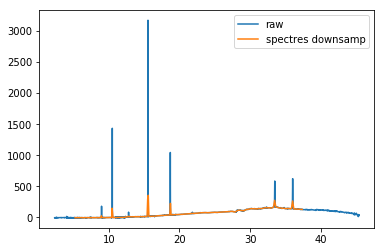

In [40]:
plt.plot(wave, flux, label='raw');
plt.plot(downsamp_wave, downsamp_flux, label='spectres downsamp')
# plt.plot(wave, smooth(flux, window_len=100), label='hanning');
# plt.plot(wave, smooth(flux, window_len=100), label='flat');
# plt.plot(wave, smooth(flux, window_len=100), label='hamming');
# plt.plot(wave, smooth(flux, window_len=100), label='bartlett');
# plt.plot(wave, smooth(flux, window_len=100), label='blackman');

# plt.xlim(xmin=10.45, xmax=10.65)
# plt.ylim(ymax=1500)|
plt.legend(loc=0)

In [44]:
np.all(downsamp_wave == cassis_wave)

True